<a href="https://colab.research.google.com/github/brucker3/KDM_spring2021/blob/main/ICP/ICP-10/ICP10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import All Required Packages
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Download Dataset
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/sentiment_analysis_tutorial/women_clothing_review.csv

--2021-04-10 22:35:39--  https://raw.githubusercontent.com/towardsai/tutorials/master/sentiment_analysis_tutorial/women_clothing_review.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8480236 (8.1M) [text/plain]
Saving to: ‘women_clothing_review.csv.5’

women_clothing_revi 100%[===================>]   8.09M  33.6MB/s    in 0.2s    

2021-04-10 22:35:40 (33.6 MB/s) - ‘women_clothing_review.csv.5’ saved [8480236/8480236]



In [24]:
# Read data from csv
df = pd.read_csv('women_clothing_review.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [25]:
# Drop unnecessary columns
df = df.drop(['Title', 'Positive Feedback Count', 'Unnamed: 0', ], axis=1)
df.dropna(inplace=True)
print(df.shape)
df

(22628, 8)


,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses
...,...,...,...,...,...,...,...,...
23481,1104,34,I was very happy to snag this dress at such a ...,5,1,General Petite,Dresses,Dresses
23482,862,48,"It reminds me of maternity clothes. soft, stre...",3,1,General Petite,Tops,Knits
23483,1104,31,"This fit well, but the top was very see throug...",3,0,General Petite,Dresses,Dresses
23484,1084,28,I bought this dress for a wedding i have this ...,3,1,General,Dresses,Dresses


In [26]:
# Calculation of Polarity
# rduce the sampling of negative and neutral 
# changed acceptalbe rate for positive to 2 so it includes more and 
# changed x ==2 for neutral to redce the neutral rate as well
df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 2 else('Neutral' if x == 2  else 'Negative'))
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,Positive
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive


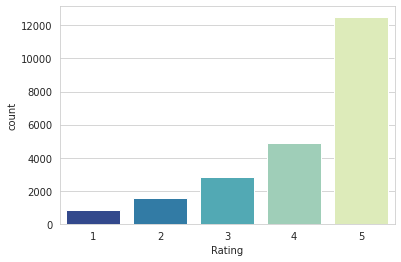

In [27]:
# Plot the Rating visualization graph
sns.set_style('whitegrid')
sns.countplot(x='Rating',data=df, palette='YlGnBu_r')

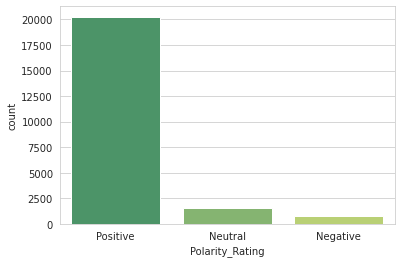

In [28]:
# Plot the Polarity Rating count
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette='summer')

In [29]:
# Data Preprocessing
df_Positive = df[df['Polarity_Rating'] == 'Positive'][0:8000]
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

In [32]:
# Sample negative and neutral polarity dataset and create final dataframe
# change sample size of negative and neutural polarity 
df_Neutral_over = df_Neutral.sample(8000, replace=True)
df_Negative_over = df_Negative.sample(8000, replace=True)

In [33]:
# Text Preprocessing
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [34]:
# Apply the method "get_text_processing" into column review text
df['review'] = df['Review Text'].apply(get_text_processing)
df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name,Polarity_Rating,review
0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,Initmates,Intimate,Intimates,Positive,Absolutely wonderful silky sexy comfortable
1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,General,Dresses,Dresses,Positive,Love dress sooo pretty happened find store im ...
2,1077,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,Positive,high hopes dress really wanted work initially ...
3,1049,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,General Petite,Bottoms,Pants,Positive,love love love jumpsuit fun flirty fabulous ev...
4,847,47,This shirt is very flattering to all due to th...,5,1,General,Tops,Blouses,Positive,shirt flattering due adjustable front tie perf...


In [35]:
# Visualize Text Review with Polarity Rating
df = df[['review', 'Polarity_Rating']]
df.head()

,review,Polarity_Rating
0,Absolutely wonderful silky sexy comfortable,Positive
1,Love dress sooo pretty happened find store im ...,Positive
2,high hopes dress really wanted work initially ...,Positive
3,love love love jumpsuit fun flirty fabulous ev...,Positive
4,shirt flattering due adjustable front tie perf...,Positive


In [36]:
# Apply One hot encoding on negative, neutral, and positive
one_hot = pd.get_dummies(df["Polarity_Rating"])
df.drop(['Polarity_Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,review,Negative,Neutral,Positive
0,Absolutely wonderful silky sexy comfortable,0,0,1
1,Love dress sooo pretty happened find store im ...,0,0,1
2,high hopes dress really wanted work initially ...,0,0,1
3,love love love jumpsuit fun flirty fabulous ev...,0,0,1
4,shirt flattering due adjustable front tie perf...,0,0,1


In [37]:
# Apply Train Test Split
X = df['review'].values
y = df.drop('review', axis=1).values
# modifying train test split origianl was 0.30 
# the new modified ration is .50 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [38]:
# Apply vectorization
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [39]:
# Apply frequency, inverse document frequency:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [40]:
# Build a deep learning model and add different layers
# model should have layers added to it 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add

#  change dropout ration 
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [41]:
# fitting Fit the Model
# change batch sizes original 254 changed to 100 
model.fit(x=X_train, y=y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

Epoch 1/10
114/114 [==============================] - 385s 3s/step - loss: 0.4126 - accuracy: 0.8674 - val_loss: 0.2911 - val_accuracy: 0.8955
Epoch 2/10
114/114 [==============================] - 378s 3s/step - loss: 0.2178 - accuracy: 0.9058 - val_loss: 0.3095 - val_accuracy: 0.8862
Epoch 3/10
114/114 [==============================] - 379s 3s/step - loss: 0.0997 - accuracy: 0.9632 - val_loss: 0.4718 - val_accuracy: 0.8745
Epoch 00003: early stopping


In [42]:
# Evaluation of Model
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

177/177 [==============================] - 107s 602ms/step - loss: 0.4718 - accuracy: 0.8745
Test accuracy: 0.8744917511940002


In [43]:
#model predictions 
preds = model.predict(X_test)
preds

array([[1.3455880e-04, 1.8527934e-03, 9.9801266e-01],
       [5.3807562e-05, 6.3166795e-03, 9.9362952e-01],
       [1.1231325e-08, 3.2660143e-06, 9.9999678e-01],
       ...,
       [1.2593799e-02, 5.0910488e-02, 9.3649572e-01],
       [1.9081010e-06, 4.6916612e-06, 9.9999344e-01],
       [6.4080063e-04, 8.3871139e-04, 9.9852055e-01]], dtype=float32)